# Walmart Sales - Easy to predict use randomforest

You are provided with historical sales data for 45 Walmart stores located in different regions. Each store contains a number of departments, and you are tasked with predicting the department-wide sales for each store.

In addition, Walmart runs several promotional markdown events throughout the year. These markdowns precede prominent holidays, the four largest of which are the Super Bowl, Labor Day, Thanksgiving, and Christmas. The weeks including these holidays are weighted five times higher in the evaluation than non-holiday weeks. Part of the challenge presented by this competition is modeling the effects of markdowns on these holiday weeks in the absence of complete/ideal historical data.

### Data Field
stores.csv

This file contains anonymized information about the 45 stores, indicating the type and size of store.

train.csv

This is the historical training data, which covers to 2010-02-05 to 2012-11-01. Within this file you will find the following fields:

Store - the store number
Dept - the department number
Date - the week
Weekly_Sales -  sales for the given department in the given store
IsHoliday - whether the week is a special holiday week
test.csv

This file is identical to train.csv, except we have withheld the weekly sales. You must predict the sales for each triplet of store, department, and date in this file.

features.csv

This file contains additional data related to the store, department, and regional activity for the given dates. It contains the following fields:

Store - the store number
Date - the week
Temperature - average temperature in the region
Fuel_Price - cost of fuel in the region
MarkDown1-5 - anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA.
CPI - the consumer price index
Unemployment - the unemployment rate
IsHoliday - whether the week is a special holiday week

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/walmart-recruiting-store-sales-forecasting/stores.csv
/kaggle/input/walmart-recruiting-store-sales-forecasting/features.csv.zip
/kaggle/input/walmart-recruiting-store-sales-forecasting/test.csv.zip
/kaggle/input/walmart-recruiting-store-sales-forecasting/sampleSubmission.csv.zip
/kaggle/input/walmart-recruiting-store-sales-forecasting/train.csv.zip


In [2]:
train = pd.read_csv("/kaggle/input/walmart-recruiting-store-sales-forecasting/train.csv.zip",parse_dates=["Date"])
test = pd.read_csv("/kaggle/input/walmart-recruiting-store-sales-forecasting/test.csv.zip",parse_dates=["Date"])

#### Add options to change date, Use parse_dates = ["Column"] Change object type to datetime type.**

In [3]:
store = pd.read_csv("/kaggle/input/walmart-recruiting-store-sales-forecasting/stores.csv")
store

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875
5,6,A,202505
6,7,B,70713
7,8,A,155078
8,9,B,125833
9,10,B,126512


In [4]:
train = pd.merge(train,store,on = "Store",how="left")
test = pd.merge(test,store,on = "Store",how="left")

#### Use Merge based (on="Column") options and left

In [5]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size
0,1,1,2010-02-05,24924.50,False,A,151315
1,1,1,2010-02-12,46039.49,True,A,151315
2,1,1,2010-02-19,41595.55,False,A,151315
3,1,1,2010-02-26,19403.54,False,A,151315
4,1,1,2010-03-05,21827.90,False,A,151315


In [6]:
test.head()

,Store,Dept,Date,IsHoliday,Type,Size
0,1,1,2012-11-02,False,A,151315
1,1,1,2012-11-09,False,A,151315
2,1,1,2012-11-16,False,A,151315
3,1,1,2012-11-23,True,A,151315
4,1,1,2012-11-30,False,A,151315


We check date in train and test have one week of day. So, We not add dt.weekofday 

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 7 columns):
Store           421570 non-null int64
Dept            421570 non-null int64
Date            421570 non-null datetime64[ns]
Weekly_Sales    421570 non-null float64
IsHoliday       421570 non-null bool
Type            421570 non-null object
Size            421570 non-null int64
dtypes: bool(1), datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 22.9+ MB


In [8]:
train["year"] = train["Date"].dt.year
train["month"] = train["Date"].dt.month
train["day"] = train["Date"].dt.day
train["week"] = train["Date"].dt.week
test["year"] = test["Date"].dt.year
test["month"] = test["Date"].dt.month
test["day"] = test["Date"].dt.day
test["week"] = test["Date"].dt.week

In [9]:
train["Type"] = train["Type"].replace({"A":0,"B":1,"C":2})
test["Type"] = test["Type"].replace({"A":0,"B":1,"C":2})

In [10]:
train = train[train["Weekly_Sales"] > -1100]

We replace in Type column's Value to 0,1,2 because Type's dtype is object 

In [11]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,year,month,day,week
0,1,1,2010-02-05,24924.50,False,0,151315,2010,2,5,5
1,1,1,2010-02-12,46039.49,True,0,151315,2010,2,12,6
2,1,1,2010-02-19,41595.55,False,0,151315,2010,2,19,7
3,1,1,2010-02-26,19403.54,False,0,151315,2010,2,26,8
4,1,1,2010-03-05,21827.90,False,0,151315,2010,3,5,9


## 2. Data EDA
### 2.1 Statistical confirmation

In [12]:
train.groupby("Store")["Weekly_Sales"].mean()

Store
1     21710.543621
2     26898.070031
3      6373.033983
4     29161.210415
5      5053.415813
6     21913.243624
7      8358.766148
8     13133.014768
9      8772.890379
10    26332.303819
11    19276.762751
12    14867.308619
13    27355.136891
14    28784.851727
15     9002.493073
16     7864.236857
17    12954.393636
18    15733.313136
19    20362.126734
20    29508.301592
21    11283.435496
22    15181.218886
23    19776.180881
24    18969.106500
25    10308.157810
26    14554.129672
27    24826.984536
28    18719.215805
29     8158.810609
30     8764.237719
31    19681.907464
32    16351.621855
33     5728.414053
34    13522.081671
35    13805.457760
36     8584.412563
37    10297.355026
38     7492.478460
39    21000.763562
40    13763.632803
41    17976.004648
42    11443.370118
43    13415.114118
44     6038.929814
45    11664.289271
Name: Weekly_Sales, dtype: float64

In [13]:
train.groupby("Store")["Weekly_Sales"].median()

Store
1     10289.375
2     14333.530
3      2804.815
4     15116.810
5      2582.660
6     13637.840
7      4575.240
8      7164.160
9      4205.470
10    13941.430
11    12322.110
12     8141.620
13    14018.455
14    15208.805
15     4798.870
16     4134.970
17     6758.145
18     9282.020
19    12410.055
20    16249.780
21     6703.750
22     8270.225
23    11993.015
24    10532.430
25     5539.170
26     7083.465
27    13625.950
28    10945.340
29     4712.540
30     1047.950
31     8511.325
32     7584.315
33      912.810
34     6680.565
35     9212.130
36     1903.285
37     1722.900
38      751.255
39    11016.425
40     6989.990
41     8927.475
42     1293.800
43     1732.530
44      799.530
45     6022.925
Name: Weekly_Sales, dtype: float64

In [14]:
train["Store"].value_counts()

13    10474
10    10315
4     10272
1     10244
2     10238
24    10228
27    10225
34    10224
20    10214
6     10211
32    10202
19    10148
31    10142
28    10111
41    10088
11    10062
23    10050
14    10040
40    10017
15     9901
8      9895
39     9878
17     9864
18     9859
26     9854
25     9804
7      9762
12     9705
22     9688
45     9636
21     9582
35     9527
29     9455
16     9442
3      9036
5      8999
9      8867
38     7362
37     7206
44     7169
30     7156
42     6953
43     6751
33     6487
36     6222
Name: Store, dtype: int64

In [15]:
train.groupby("day")["Weekly_Sales"].mean()

day
1     15438.693561
2     16284.190735
3     16243.591840
4     16262.123390
5     16152.185352
6     16540.152518
7     15851.075764
8     16028.047405
9     16564.470980
10    16684.753968
11    15946.176870
12    15769.983633
13    15358.628217
14    14843.544775
15    15476.565690
16    16400.916009
17    16890.881861
18    15914.848035
19    15634.121093
20    15236.067426
21    14987.074671
22    15696.588300
23    17183.530448
24    17732.369226
25    16817.955895
26    16743.733480
27    14908.182971
28    15056.847856
29    15117.011770
30    15038.411334
31    14833.557736
Name: Weekly_Sales, dtype: float64

In [16]:
train.groupby("IsHoliday")["Weekly_Sales"].median()

IsHoliday
False    7590.045
True     7947.740
Name: Weekly_Sales, dtype: float64

In [17]:
train.groupby("year")["Weekly_Sales"].median()

year
2010    7964.65
2011    7522.15
2012    7365.38
Name: Weekly_Sales, dtype: float64

In [18]:
train.groupby("Type")["Weekly_Sales"].mean()

Type
0    20099.783889
1    12237.345618
2     9519.532538
Name: Weekly_Sales, dtype: float64

In [19]:
holiday = train[(train.IsHoliday==1)]

In [20]:
holiday

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,year,month,day,week
1,1,1,2010-02-12,46039.49,True,0,151315,2010,2,12,6
31,1,1,2010-09-10,18194.74,True,0,151315,2010,9,10,36
42,1,1,2010-11-26,18820.29,True,0,151315,2010,11,26,47
47,1,1,2010-12-31,19124.58,True,0,151315,2010,12,31,52
53,1,1,2011-02-11,37887.17,True,0,151315,2011,2,11,6
...,...,...,...,...,...,...,...,...,...,...,...
421510,45,98,2011-09-09,1092.66,True,1,118221,2011,9,9,36
421521,45,98,2011-11-25,794.62,True,1,118221,2011,11,25,47
421526,45,98,2011-12-30,553.21,True,1,118221,2011,12,30,52
421532,45,98,2012-02-10,770.86,True,1,118221,2012,2,10,6


In [21]:
train.groupby("year")["Weekly_Sales"].mean()

year
2010    16270.554955
2011    15954.312796
2012    15695.085088
Name: Weekly_Sales, dtype: float64

In [22]:
train["year"].value_counts()

2011    153451
2010    140677
2012    127437
Name: year, dtype: int64

In [23]:
train.groupby("month")["Weekly_Sales"].mean()

month
1     14126.075111
2     16009.279112
3     15417.538083
4     15650.338357
5     15776.337202
6     16326.137002
7     15861.419650
8     16062.516933
9     15096.382265
10    15244.383007
11    17491.031424
12    19355.702141
Name: Weekly_Sales, dtype: float64

### 2.2 Data visualization

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

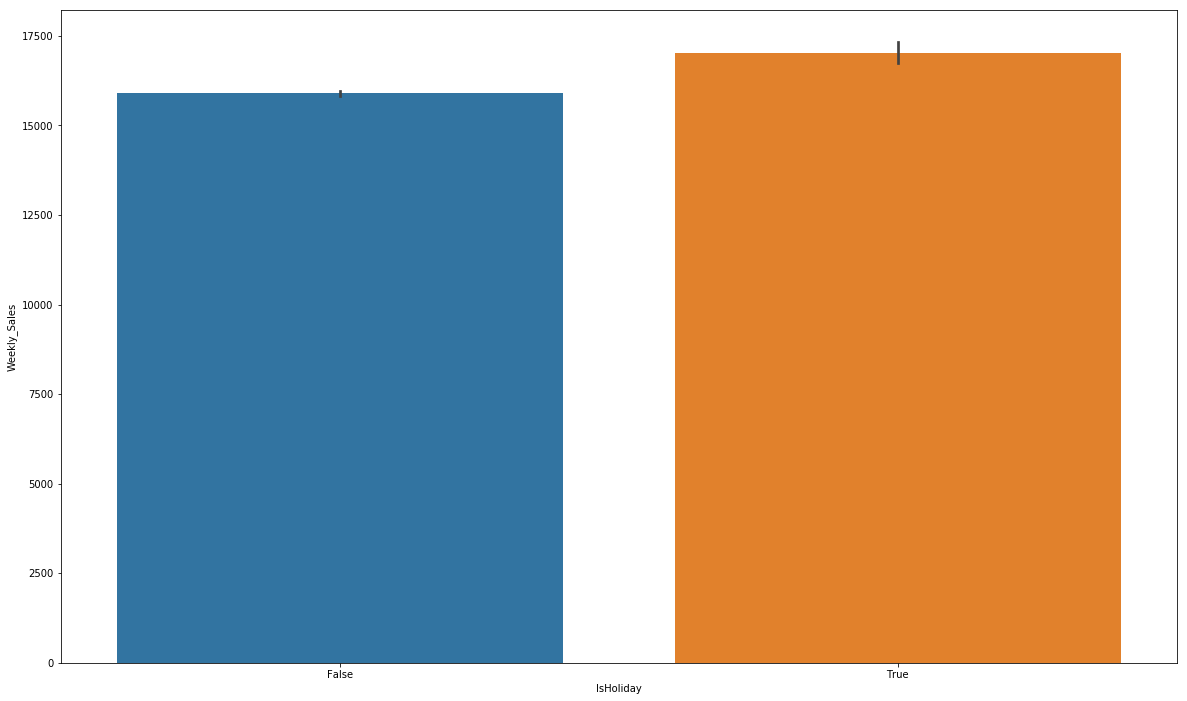

In [25]:
plt.figure(figsize=(20,12))
sns.barplot(train["IsHoliday"],train["Weekly_Sales"])

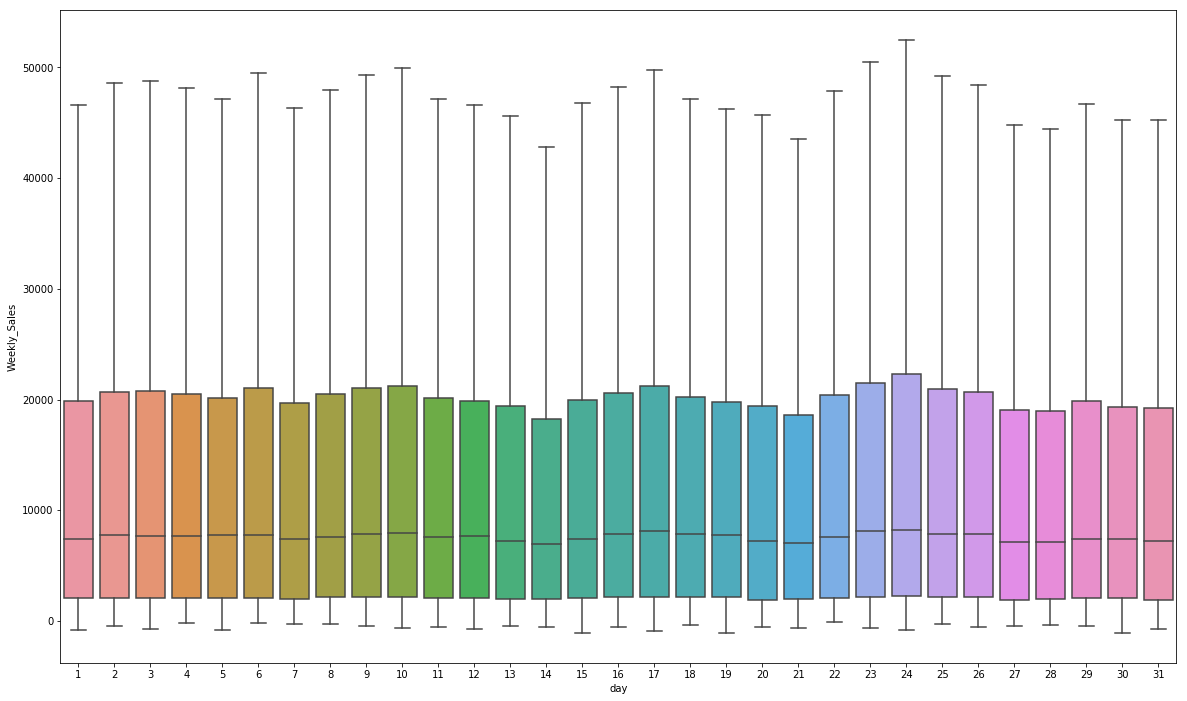

In [26]:
plt.figure(figsize=(20,12))
sns.boxplot(train["day"],train["Weekly_Sales"],showfliers=False)

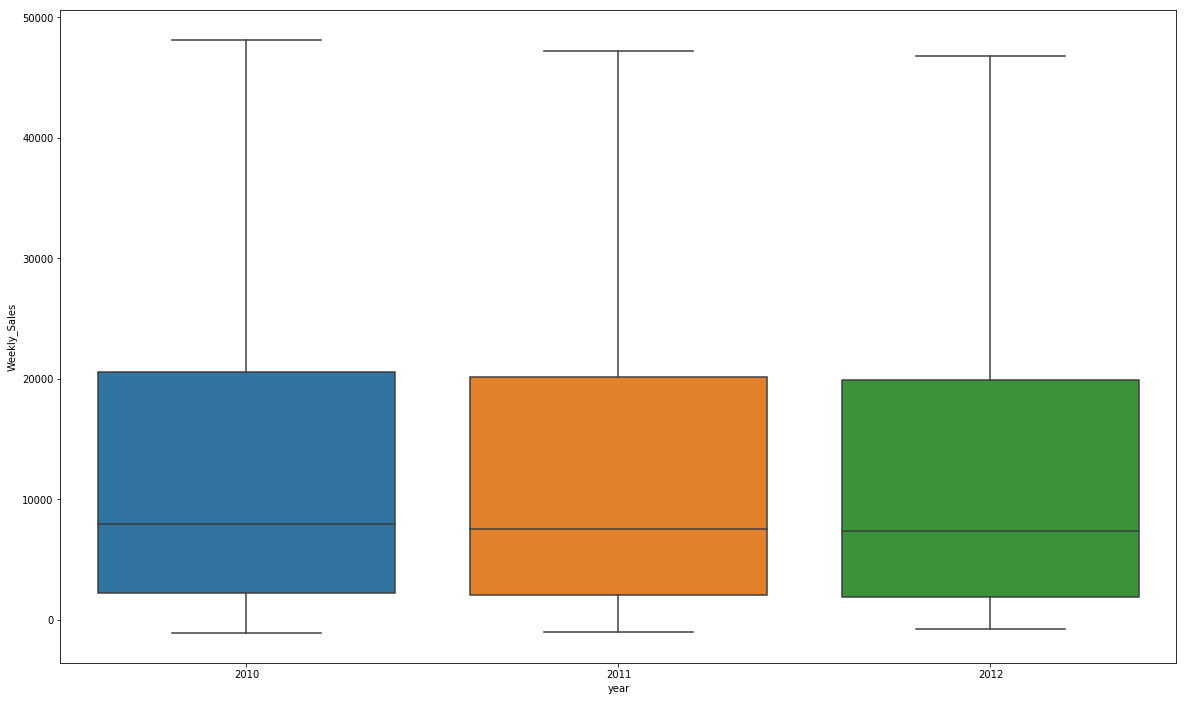

In [27]:
plt.figure(figsize=(20,12))
sns.boxplot(train["year"],train["Weekly_Sales"],showfliers=False)

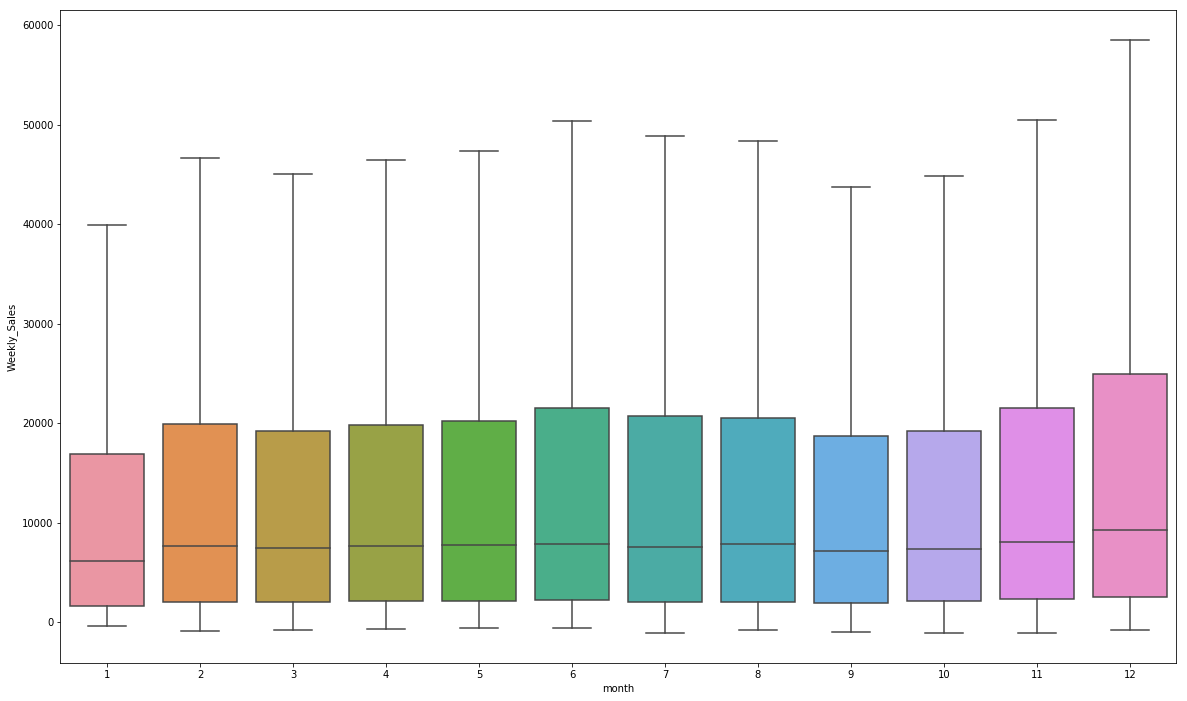

In [28]:
plt.figure(figsize=(20,12))
sns.boxplot(train["month"],train["Weekly_Sales"],showfliers=False)

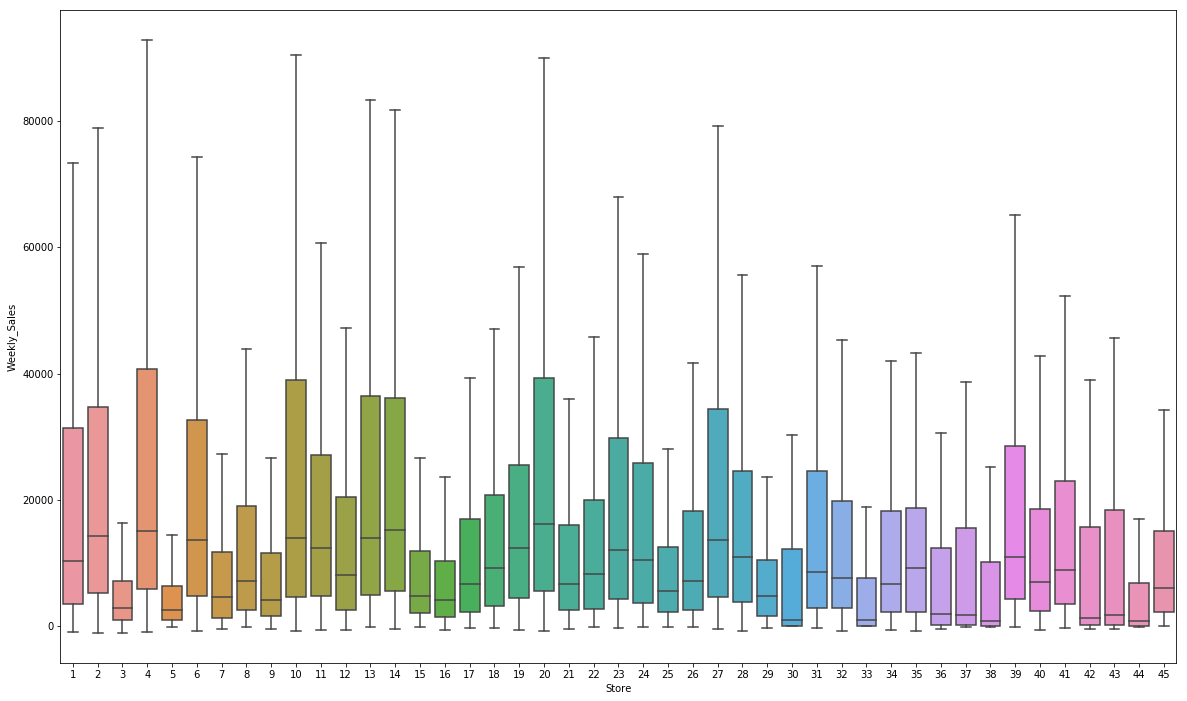

In [29]:
plt.figure(figsize=(20,12))
sns.boxplot(train["Store"],train["Weekly_Sales"],showfliers=False)

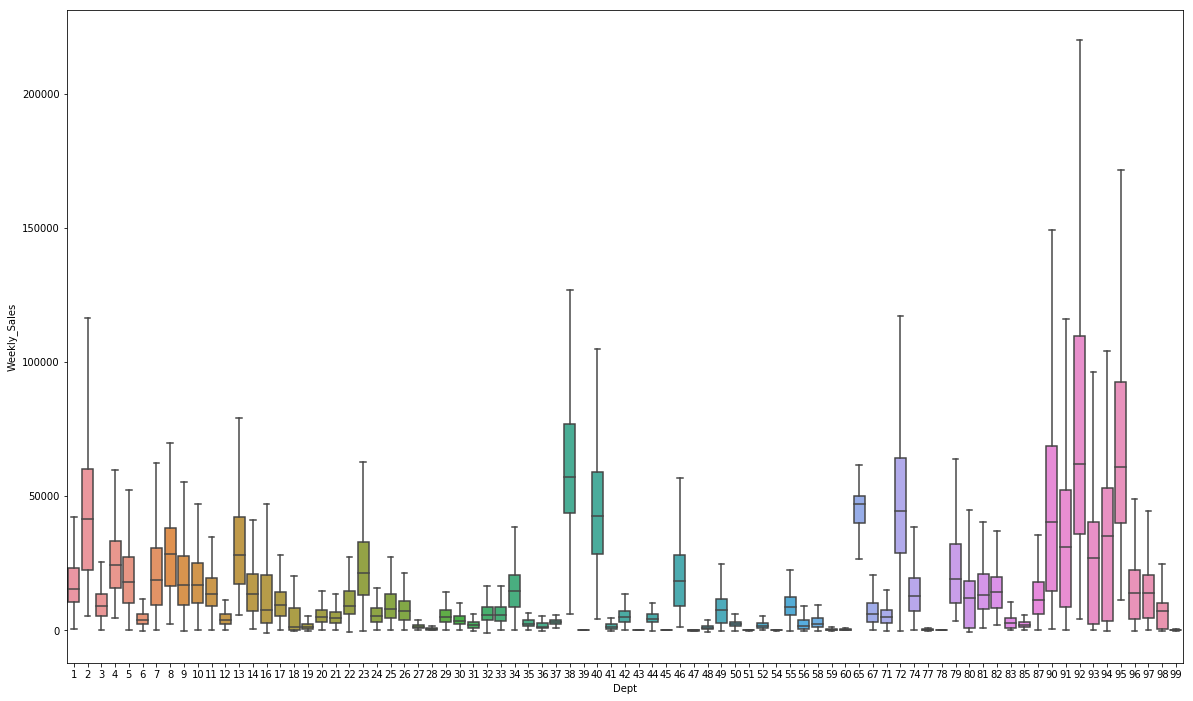

In [30]:
plt.figure(figsize=(20,12))
sns.boxplot(train["Dept"],train["Weekly_Sales"],showfliers=False)

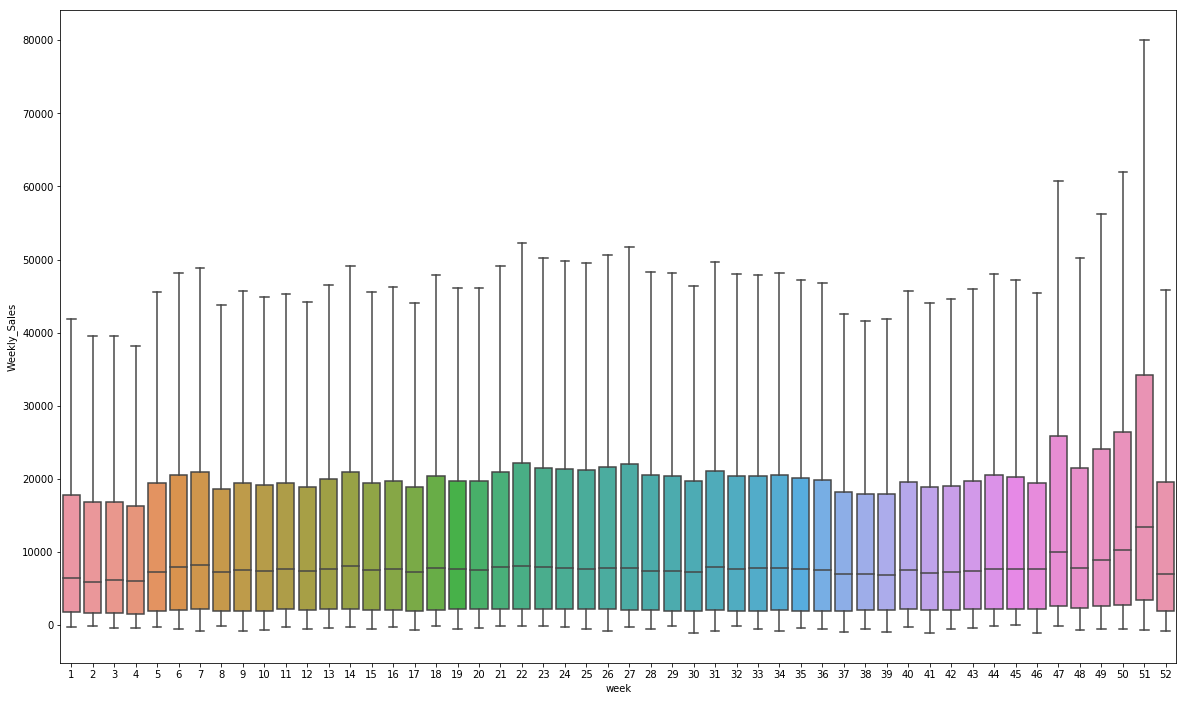

In [31]:
plt.figure(figsize=(20,12))
sns.boxplot(train["week"],train["Weekly_Sales"],showfliers=False)

In [32]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,year,month,day,week
0,1,1,2010-02-05,24924.50,False,0,151315,2010,2,5,5
1,1,1,2010-02-12,46039.49,True,0,151315,2010,2,12,6
2,1,1,2010-02-19,41595.55,False,0,151315,2010,2,19,7
3,1,1,2010-02-26,19403.54,False,0,151315,2010,2,26,8
4,1,1,2010-03-05,21827.90,False,0,151315,2010,3,5,9


## 3. Feature engineering

In [33]:
feature = ["Store","Dept","IsHoliday","year","month","day","week","Type","Size"]

In [34]:
x_train = train[feature]
x_test = test[feature]

In [35]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421565 entries, 0 to 421569
Data columns (total 9 columns):
Store        421565 non-null int64
Dept         421565 non-null int64
IsHoliday    421565 non-null bool
year         421565 non-null int64
month        421565 non-null int64
day          421565 non-null int64
week         421565 non-null int64
Type         421565 non-null int64
Size         421565 non-null int64
dtypes: bool(1), int64(8)
memory usage: 49.3 MB


In [36]:
x_test.head()

,Store,Dept,IsHoliday,year,month,day,week,Type,Size
0,1,1,False,2012,11,2,44,0,151315
1,1,1,False,2012,11,9,45,0,151315
2,1,1,False,2012,11,16,46,0,151315
3,1,1,True,2012,11,23,47,0,151315
4,1,1,False,2012,11,30,48,0,151315


In [37]:
y_train = train["Weekly_Sales"]

In [38]:
y_train.describe()

count    421565.000000
mean      15981.480129
std       22711.226166
min       -1098.000000
25%        2079.820000
50%        7612.100000
75%       20206.160000
max      693099.360000
Name: Weekly_Sales, dtype: float64

In [39]:
train[train["Weekly_Sales"] < 0]

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,year,month,day,week
846,1,6,2012-08-10,-139.65,False,0,151315,2012,8,10,32
2384,1,18,2012-05-04,-1.27,False,0,151315,2012,5,4,18
6048,1,47,2010-02-19,-863.00,False,0,151315,2010,2,19,7
6049,1,47,2010-03-12,-698.00,False,0,151315,2010,3,12,10
6051,1,47,2010-10-08,-58.00,False,0,151315,2010,10,8,40
...,...,...,...,...,...,...,...,...,...,...,...
419597,45,80,2010-02-12,-0.43,True,1,118221,2010,2,12,6
419598,45,80,2010-02-19,-0.27,False,1,118221,2010,2,19,7
419603,45,80,2010-04-16,-1.61,False,1,118221,2010,4,16,15
419614,45,80,2010-07-02,-0.27,False,1,118221,2010,7,2,26


In [40]:
y_train.sort_values().head(30)

16297    -1098.00
16295    -1098.00
16291    -1098.00
24830    -1008.96
35561     -898.00
6048      -863.00
93591     -798.00
193325    -798.00
93581     -798.00
93573     -798.00
193320    -778.50
332894    -771.90
273030    -705.00
54835     -698.00
309907    -698.00
6049      -698.00
183087    -649.00
183079    -649.00
113819    -598.00
193313    -598.00
193314    -598.00
326511    -598.00
103848    -594.00
155677    -590.04
113820    -548.14
113837    -548.00
376930    -543.00
93586     -515.00
153908    -500.00
183074    -499.00
Name: Weekly_Sales, dtype: float64

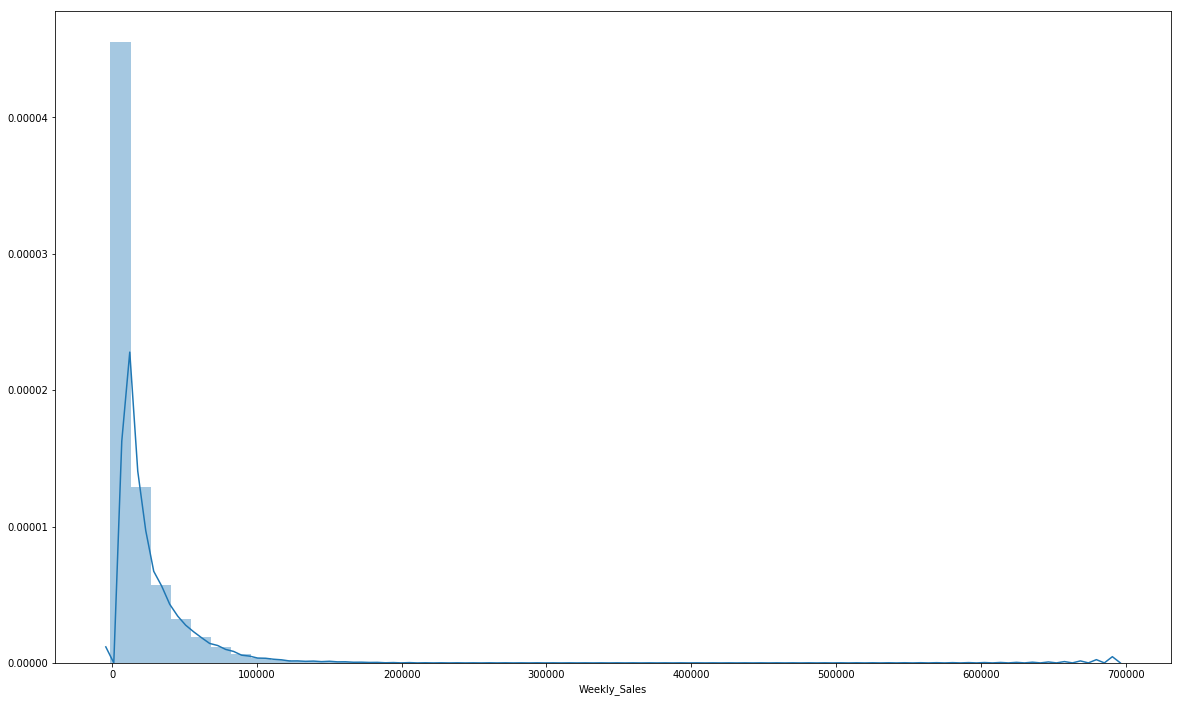

In [41]:
plt.figure(figsize=(20,12))
sns.distplot(y_train)

In [42]:
y_train = train["Weekly_Sales"] + 1100

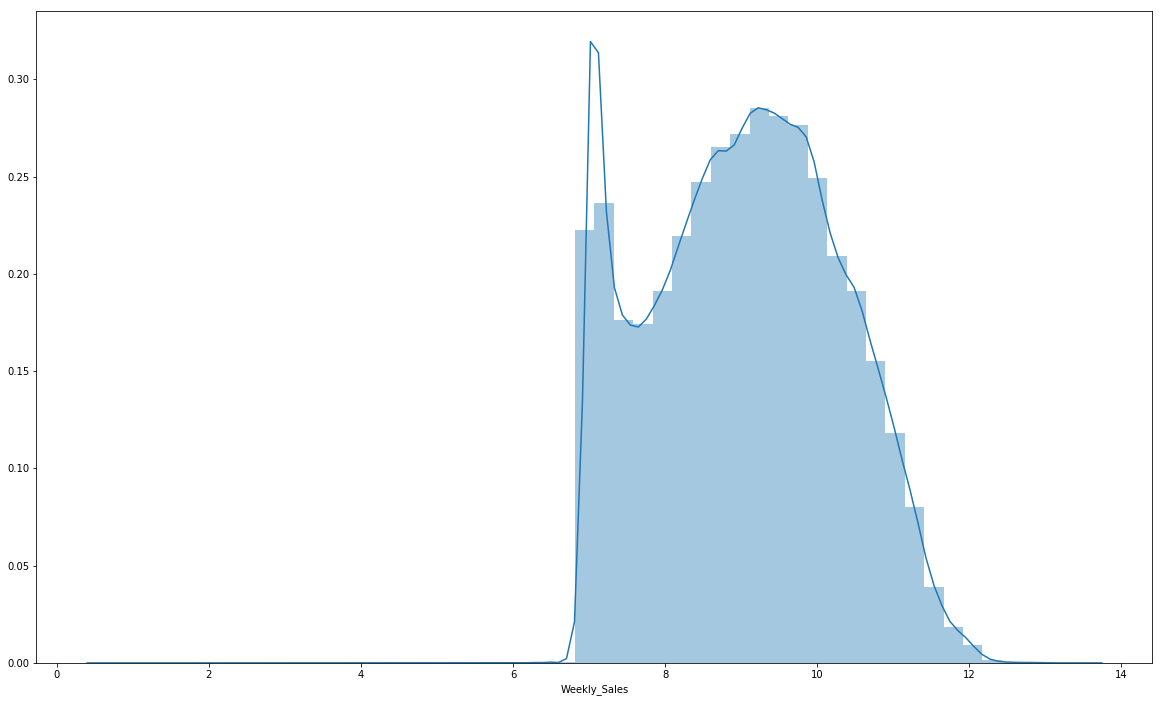

In [43]:
plt.figure(figsize=(20,12))
sns.distplot(np.log(y_train))

In [44]:
y_train.describe()

count    421565.000000
mean      17081.480129
std       22711.226166
min           2.000000
25%        3179.820000
50%        8712.100000
75%       21306.160000
max      694199.360000
Name: Weekly_Sales, dtype: float64

In [45]:
y_train.sort_values().head(30)

16297       2.00
16295       2.00
16291       2.00
24830      91.04
35561     202.00
6048      237.00
93591     302.00
193325    302.00
93581     302.00
93573     302.00
193320    321.50
332894    328.10
273030    395.00
54835     402.00
309907    402.00
6049      402.00
183087    451.00
183079    451.00
113819    502.00
193313    502.00
193314    502.00
326511    502.00
103848    506.00
155677    509.96
113820    551.86
113837    552.00
376930    557.00
93586     585.00
153908    600.00
183074    601.00
Name: Weekly_Sales, dtype: float64

## 4. Modeling

In [46]:
# %%time
# from sklearn.ensemble import RandomForestRegressor
# model = RandomForestRegressor(n_estimators=100,n_jobs=4)


# model.fit(x_train,np.log(y_train))

# result = model.predict(x_test)
from lightgbm import LGBMRegressor
model = LGBMRegressor()
model.fit(x_train,np.log(y_train))
result = model.predict(x_test)

In [47]:
result

array([10.06782839, 10.07679249, 10.07211352, ...,  7.49426975,
        7.49238914,  7.48912962])

In [48]:
sub = pd.read_csv("/kaggle/input/walmart-recruiting-store-sales-forecasting/sampleSubmission.csv.zip")

In [49]:
sub.head()

,Id,Weekly_Sales
0,1_1_2012-11-02,0
1,1_1_2012-11-09,0
2,1_1_2012-11-16,0
3,1_1_2012-11-23,0
4,1_1_2012-11-30,0


In [50]:
sub["Weekly_Sales"] = np.exp(result) - 1100
sub.head()

,Id,Weekly_Sales
0,1_1_2012-11-02,22472.319212
1,1_1_2012-11-09,22684.573720
2,1_1_2012-11-16,22573.546491
3,1_1_2012-11-23,26555.171152
4,1_1_2012-11-30,24375.997254


In [51]:
sub.to_csv("walmart_predict_sub.csv",index=False)